# Cosmic ray removal

Almost all images from a CCD will include some number of cosmic rays, charged
particles which bombard the Earth's upper atmosphere. Some of those will make it
through the atmosphere and into your detector (the rate of cosmic rays will be
much higher for cameras in space). Although the number of cosmic rays is roughly
proportional to exposure time, there will be cosmic rays even in bias frames in
which the chip is immediately read out.

This notebook explains how to remove cosmic rays from calibration images and
science images.

## Removal from calibration images

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R24){:target="_blank"}

The easiest way to remove cosmic rays from calibration images (bias, dark and
flat images) is to combine them properly. Cosmic rays are, by their nature,
random events that will affect different parts of each of the calibration
images. A pixel affected by a cosmic ray in one of the dark images, for example,
will almost certainly *not* be affected by a cosmic ray in any of the other dark
images.

Combining those images by averaging (to reduce noise as much as possible) and
sigma clipping (to exclude extreme pixels in individual images like the one with
a cosmic ray) will eliminate the cosmic ray from the combined dark image. An
alternative would be to combine the images using a median. A detailed
description of each option is discussed in the [section on image combination](01-06-Image-combination.html).

The method described below for removing cosmic rays from science images will not
work well for removing them from calibration images and is unnecessary because
they can be removed by properly combining the images.

## Removal from science images

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R48){:target="_blank"}

One good technique for removing cosmic rays from an image is the
[LACosmic method](http://www.astro.yale.edu/dokkum/lacosmic/) originally developed and implemented for IRAF
by [Pieter G. van Dokkum](https://www.pietervandokkum.com/). The original paper describing the method,
which uses the sharp edges of cosmic rays to distinguish them from other sources
in the image, is [here](http://adsabs.harvard.edu/abs/2001PASP..113.1420V).


The specific implementation of LACosmic used here is the astropy affiliated
package [Astro-SCRAPPY](https://github.com/astropy/astroscrappy). If you use this code to remove cosmic
rays you should cite both the original paper and
[Astro-SCRAPPY](https://github.com/astropy/astroscrappy) (citation details are on its web site). The
code below never directly imports [Astro-SCRAPPY](https://github.com/astropy/astroscrappy) because
ccdproc provides a wrapper for it, so we called attention to it here.

### Very important notes about using LACosmic

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R69){:target="_blank"}

There are a few things to be aware of before using the LACosmic technique. These
are drawn from the advice van Dokkum provides under
[Notes for Users](http://www.astro.yale.edu/dokkum/lacosmic/) and the original paper.

1. The images must be bias and dark subtracted.
2. The images should be flat fielded, though the technique can be applied
without flat fielding.
3. The images should **not** have the sky subtracted before detecting the cosmic
rays.
4. The noise level in the image needs to be accurately measured.
5. The image and the noise have to be in the same units, typically electrons.
1. If there are pixels that are known to be bad (e.g. hot pixels, pixels
identified by `ccdmask`) they should be masked out before detecting cosmic rays.

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from astropy.nddata import CCDData
from astropy.nddata.utils import block_replicate
from astropy import units as u
import ccdproc as ccdp
from photutils import detect_sources

from astrowidgets import ImageWidget

from convenience_functions import show_image, display_cosmic_rays

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

In [3]:
from sidecar import Sidecar

### Input image

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R131){:target="_blank"}

The image we will use in this notebook is one of the reduced images from Example
2 in the previous notebooks. It is an image of the field of the exoplanet
Kelt-16b, taken with a thermo-electrically cooled CCD with read noise of 10$e^-$
and gain of $1.5~e^-$/ADU.

In [4]:
ex2_path = Path('example2-reduced')

ccd = CCDData.read(ex2_path / 'kelt-16-b-S001-R001-C084-r.fit')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


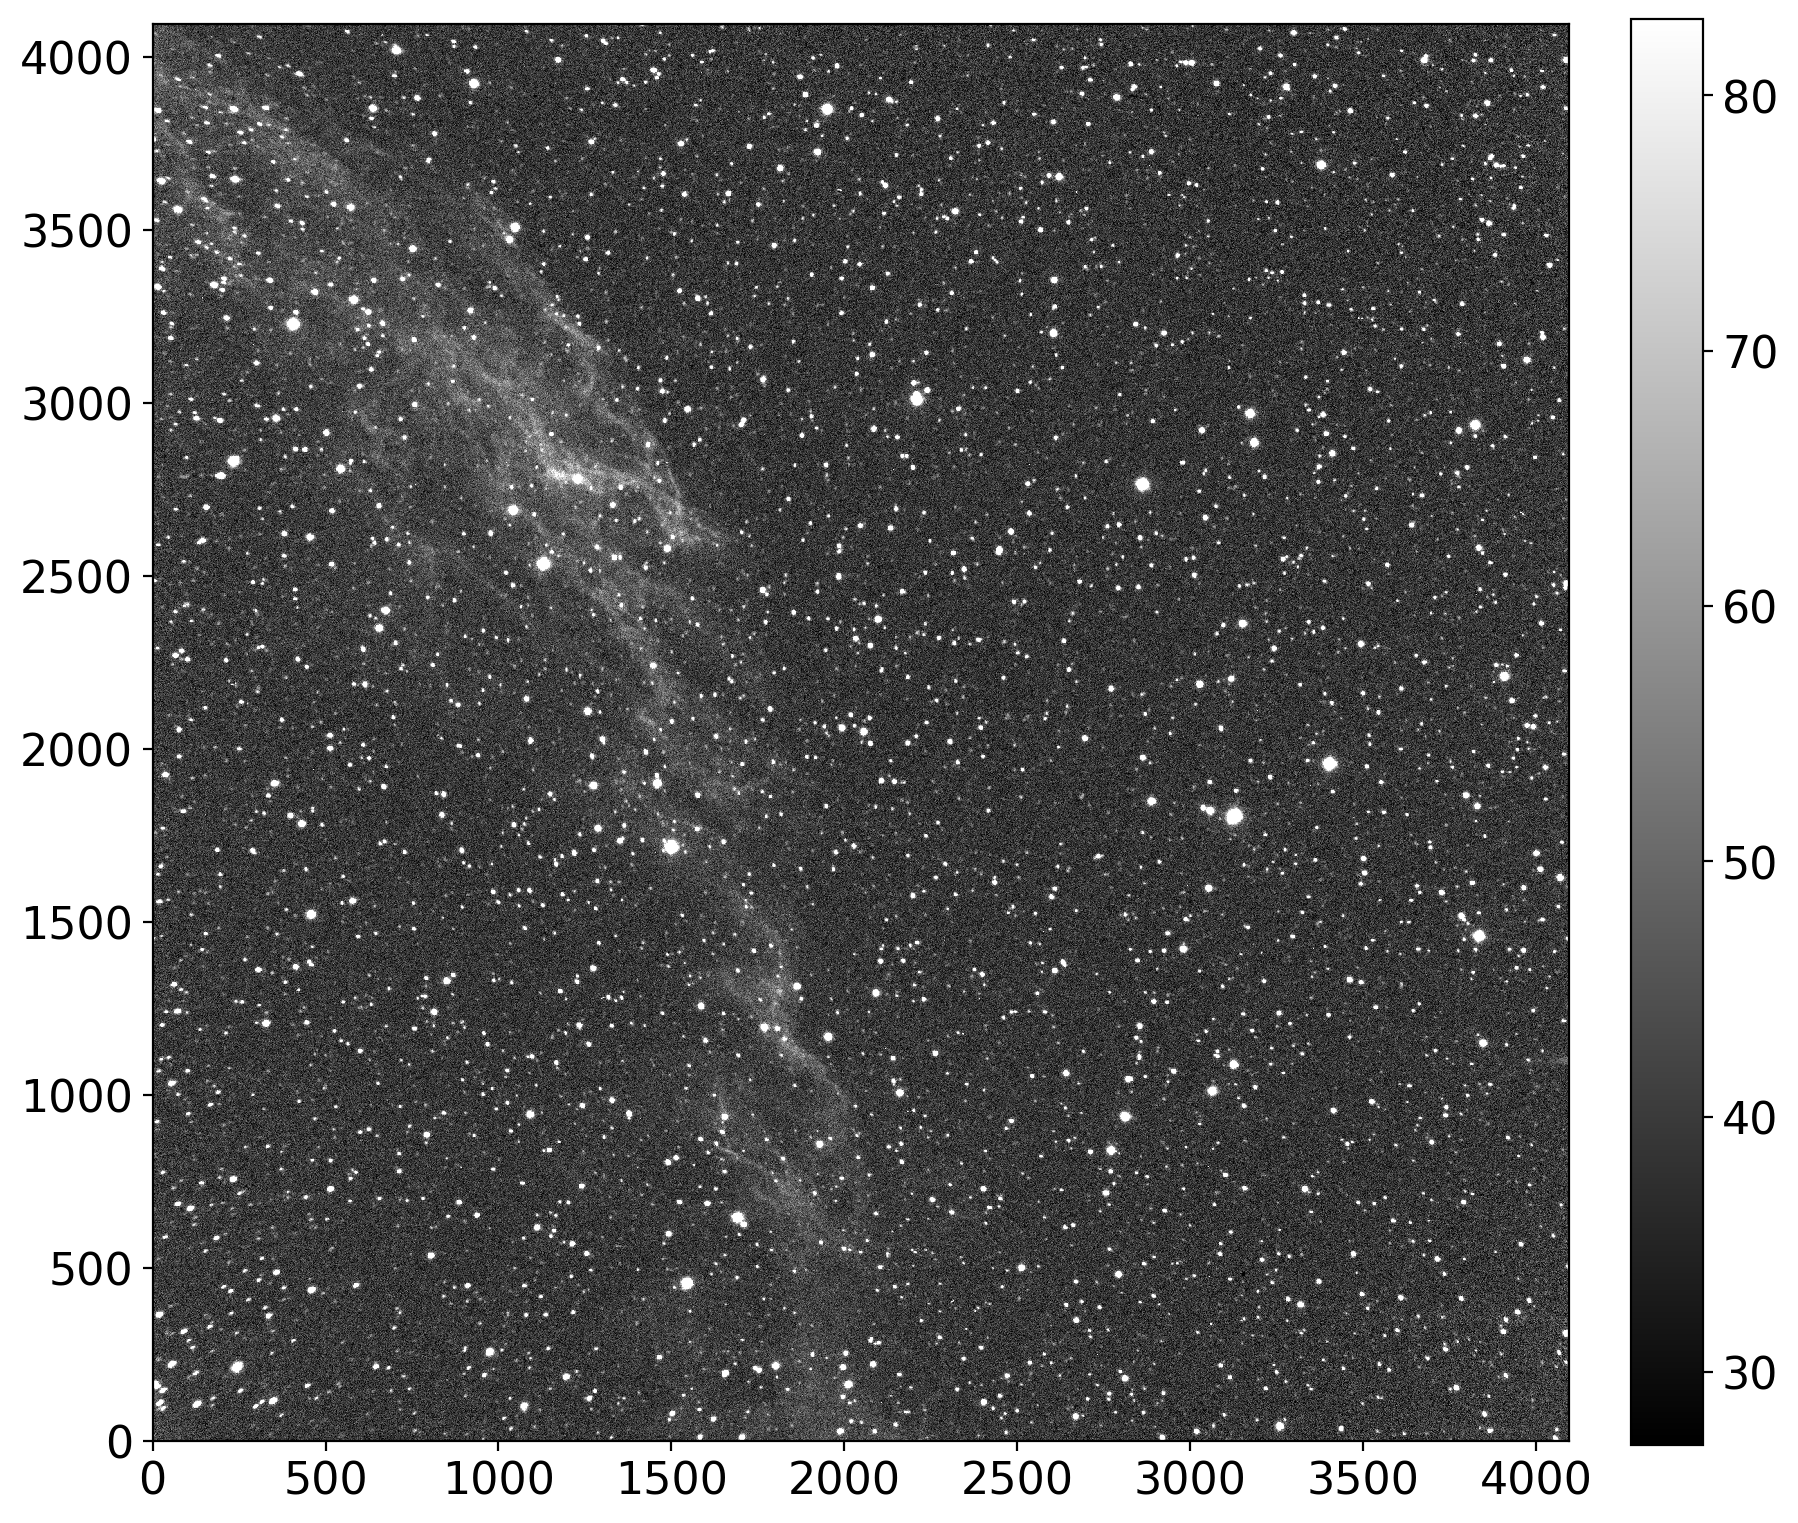

In [5]:
show_image(ccd, cmap='gray')

The unit of this image is ADU, so we need to multiply by the gain to convert to
electrons.

In [6]:
ccd = ccdp.gain_correct(ccd, 1.5 * u.electron / u.adu)

### Reading in and applying masks

Two masks were calculated earlier. Hot pixels, whose dark current cannot be
corrected, were [identified by comparing dark frames of different exposure time](08-01-Identifying-hot-pixels.html).  The
[function `ccdmask` was used](08-02-Creating-a-mask) to identify other bad pixels; one example was a
column of pixels on the left side of the image.

We read in both of the masks, which are the same for all images, and combine
using logical or.

In [7]:
dark_mask = CCDData.read(ex2_path / 'mask_from_dark_current.fits', unit=u.dimensionless_unscaled)

In [8]:
ccdmask_mask = CCDData.read(ex2_path / 'mask_from_ccdmask.fits', unit=u.dimensionless_unscaled)

In [9]:
combined_mask = dark_mask.data | ccdmask_mask.data

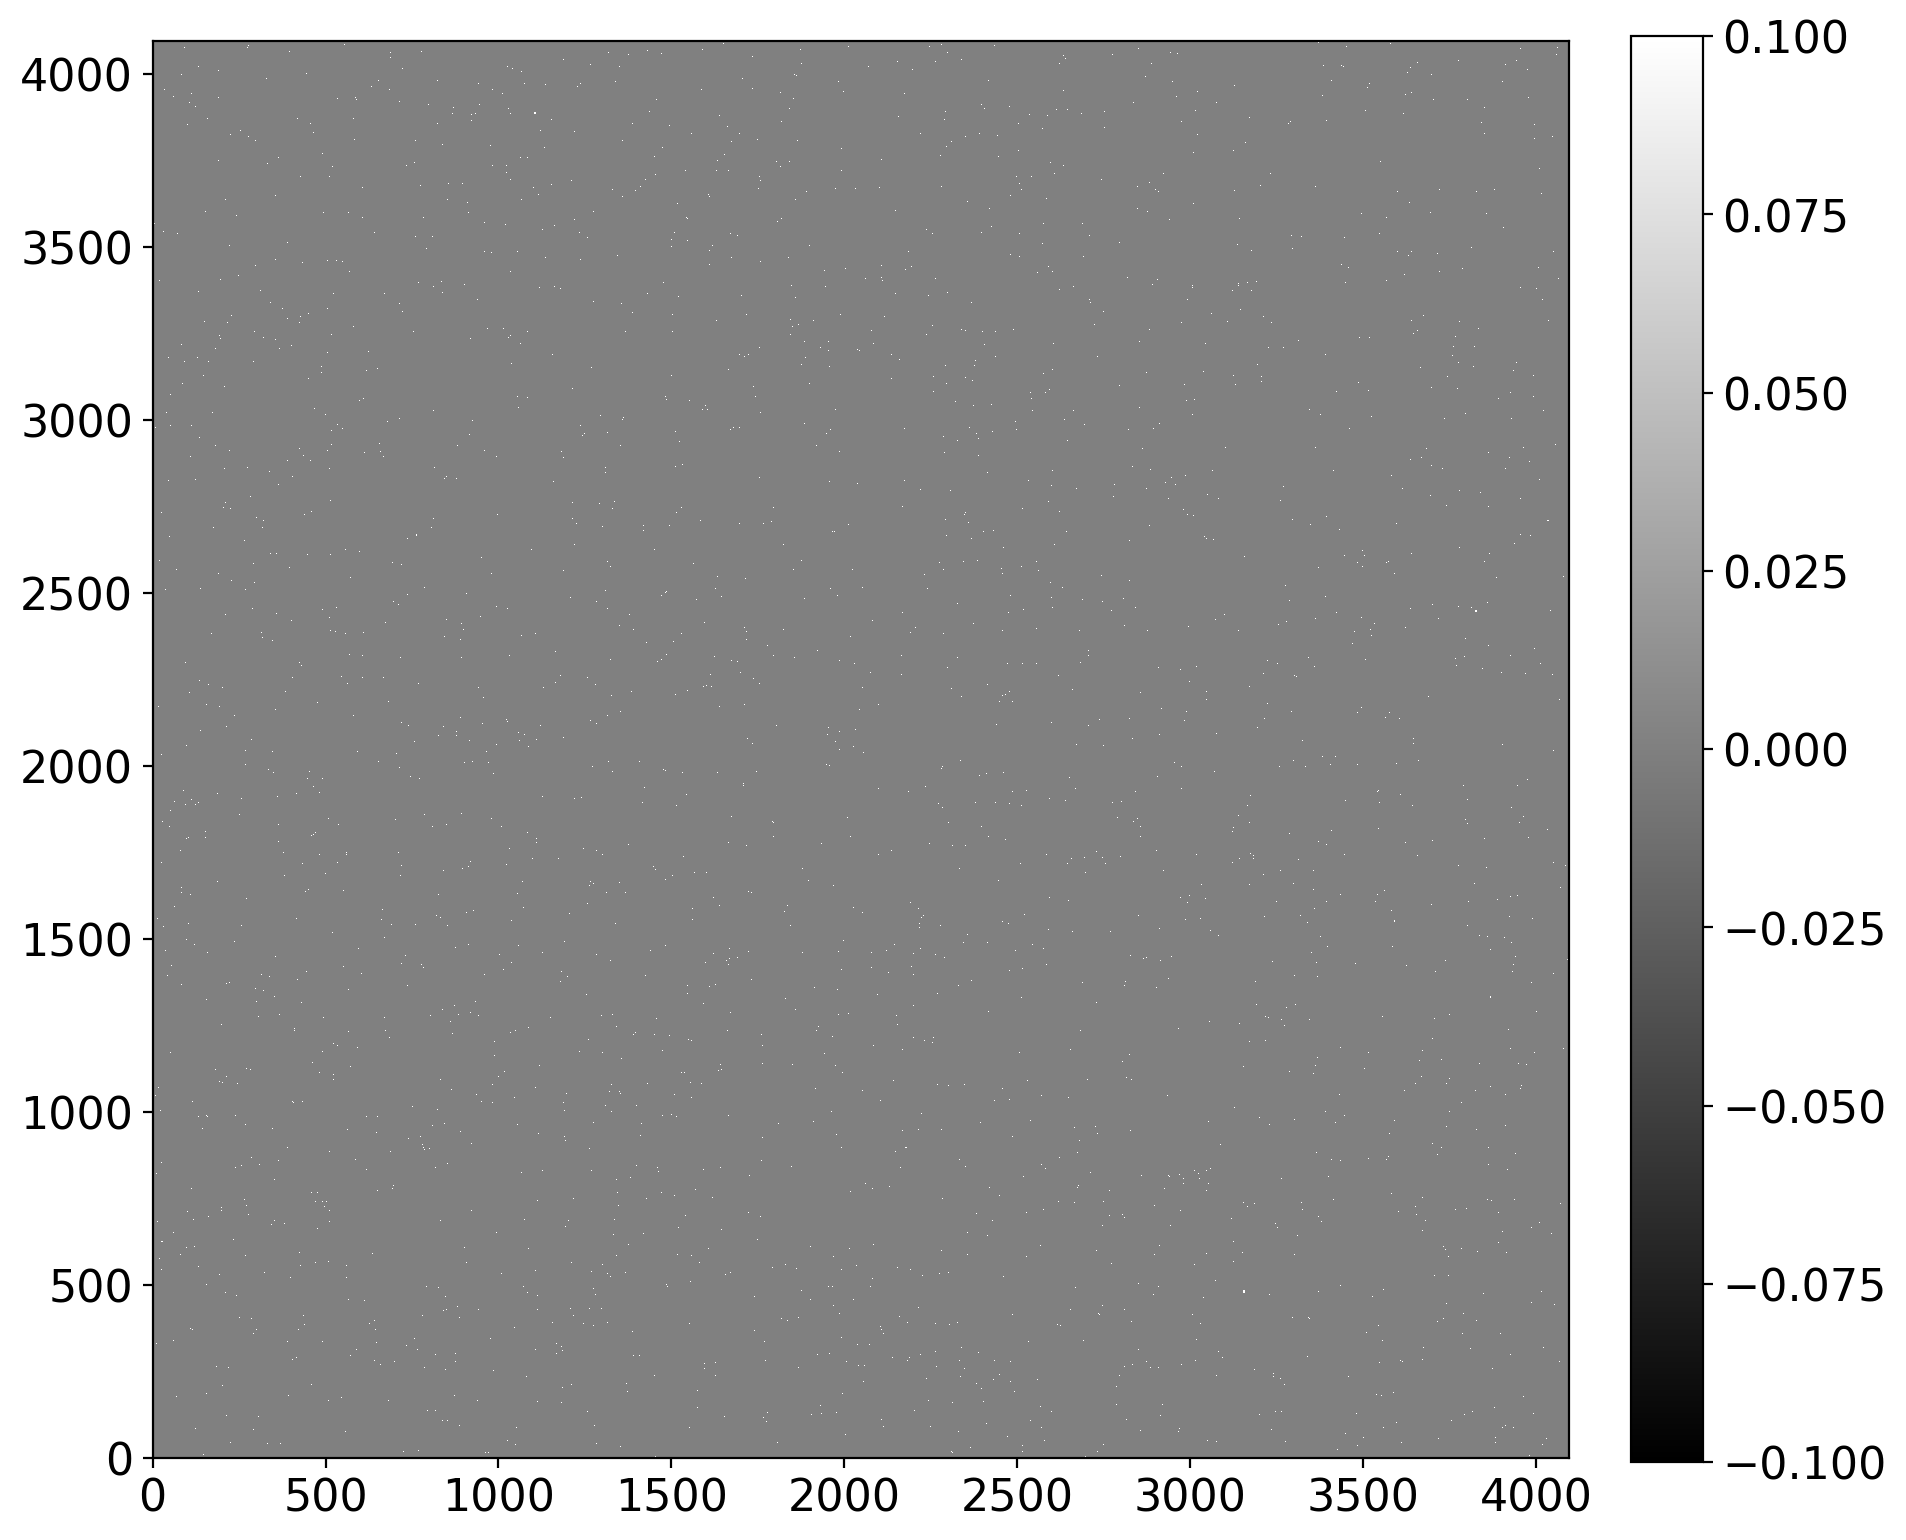

In [10]:
show_image(combined_mask, cmap='gray')

Excluding these pixels from cosmic ray detection ensures that only cosmic rays
are  identified.

The mask is now applied to the image of Kelt 16.

In [11]:
ccd.mask = combined_mask

### Running LACosmic

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R255){:target="_blank"}

The actual invocation of LACosmic is fairly straightforward. The key parameters
are `readnoise`, the read noise, and `sigclip`, which determines how far above
the background a pixel needs to be to consider it a cosmic ray. There is no
hard-and-fast rule for selecting the proper value of `sigclip`. In the original
paper a value of 5 is recommended, but for this image it finds several thousand
pixels contaminated by cosmic rays. That is not plausible for an image taken
with a camera a thousand feet above sea level.

Higher values of `sigclip` reduce the number of cosmic rays found. The value
used below, 7, seemed to work well for this image, finding a total of roughly 70
pixels that are cosmic rays, and a couple dozen candidate cosmic rays that
extend across multiple pixels.

The function [`cosmicray_lacosmic`]() from ccdproc returns a new image in which
the mask is `True` for pixels in which a cosmic ray was detected and `False`
otherwise. The data in the new image has values in the pixels in which cosmic
rays were identified replaced by interpolating the neighboring pixels.

We will take a look at the cosmic rays identified by LACosmic in a moment.

Expect the code below to take at a few tens of seconds to run.

In [12]:
%%time
new_ccd = ccdp.cosmicray_lacosmic(ccd, readnoise=10, sigclip=7, verbose=True)

Starting 4 L.A.Cosmic iterations
Iteration 1:
153 cosmic pixels this iteration
Iteration 2:
7 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration
CPU times: user 17 s, sys: 1.1 s, total: 18.1 s
Wall time: 18.1 s


The mask of `new_ccd` includes both cosmic rays identified by
`cosmicray_lacosmic` and the mask we applied to `ccd` above. To get only the
cosmic rays, we set the mask to `False` for all of those pixels that were masked
before LACosmic ran.

In [13]:
cr_mask = new_ccd.mask
cr_mask[ccd.mask] = False

The sum of the mask indicates how many pixels have been identified as cosmic
rays.

In [14]:
new_ccd.mask.sum() 

160

### Examining the cosmic rays identified by LACosmic

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R331){:target="_blank"}

There are 70 pixels that have been flagged as cosmic rays. Looking through each
of them individually would be tedious, at best. It would also presumably be
difficult to decide visually if a single pixel tagged as a cosmic ray was
actually a cosmic ray, but it would be helpful to look at the larger cosmic
rays, i.e. those that span multiple pixels.

To identify those larger cosmic rays we will use the function `detect_sources`
from the package [photutils](https://photutils.readthedocs.io), which identifies contiguous
pixels in an image via image segmentation. Though
[`detect_sources`]() is intended for detecting extended or stellar  sources in an image it happens to work very well for identifying extended cosmic rays in the mask generated by [`cosmicray_lacosmic`]().

The threshold below should be something less than 1 to ensure that only the
masked pixels, i.e. those whose values are 1, are included as sources. The
number of pixels is the number which must be adjacent (either by edge or by
corner) to be considered a source.

In [15]:
threshold = 0.5
n_pixels = 3
crs = detect_sources(new_ccd.mask, threshold, n_pixels)

We first check to see how many of the pixels identified by LACosmic are part of
these extended cosmic rays.

In [16]:
crs.areas

array([4, 3, 3, 3, 7, 3, 7, 8, 8, 3, 3, 5, 3, 7, 4, 3, 4, 3, 4])

Looks like about 50% of the pixels marked as cosmic rays are extended over
multiple adjacent pixels

In this particular science image there are three things being identified as
cosmic rays:

+ Actual cosmic rays.
+ Single hot pixels, i.e. pixels with unusually high dark current.

These conclusions are not at all clear from what we have discussed in this
notebook so far. They are based on a detailed examination of the images after
looking at thumbnail views of the cosmic ray mask, the science image in which
the cosmic rays were detected and the combined dark frame that was used to
calibrate this science image.

That thumbnail view turned out to be a useful enough comparison that a function
called `display_cosmic_rays` is provided in `convenience_functions.py` that will
display the cosmic ray mask and as many additional comparison images as you
would like.

Since one of the images it turns out to be useful to look at in this example is
the combined dark used in calibrating the science image, we load it.

In [17]:
ccd_dark = CCDData.read(ex2_path / 'combined_dark_90.000.fit')

One note about the argument `only_display_rays` below, which restricts the
cosmic rays that are displayed to that list. The list was chosen by first
viewing *all* of the cosmic rays and choosing a representative sample for
inclusion in this discussion. Display them all by setting
`only_display_rays=None` in the call to `display_cosmic_rays`.

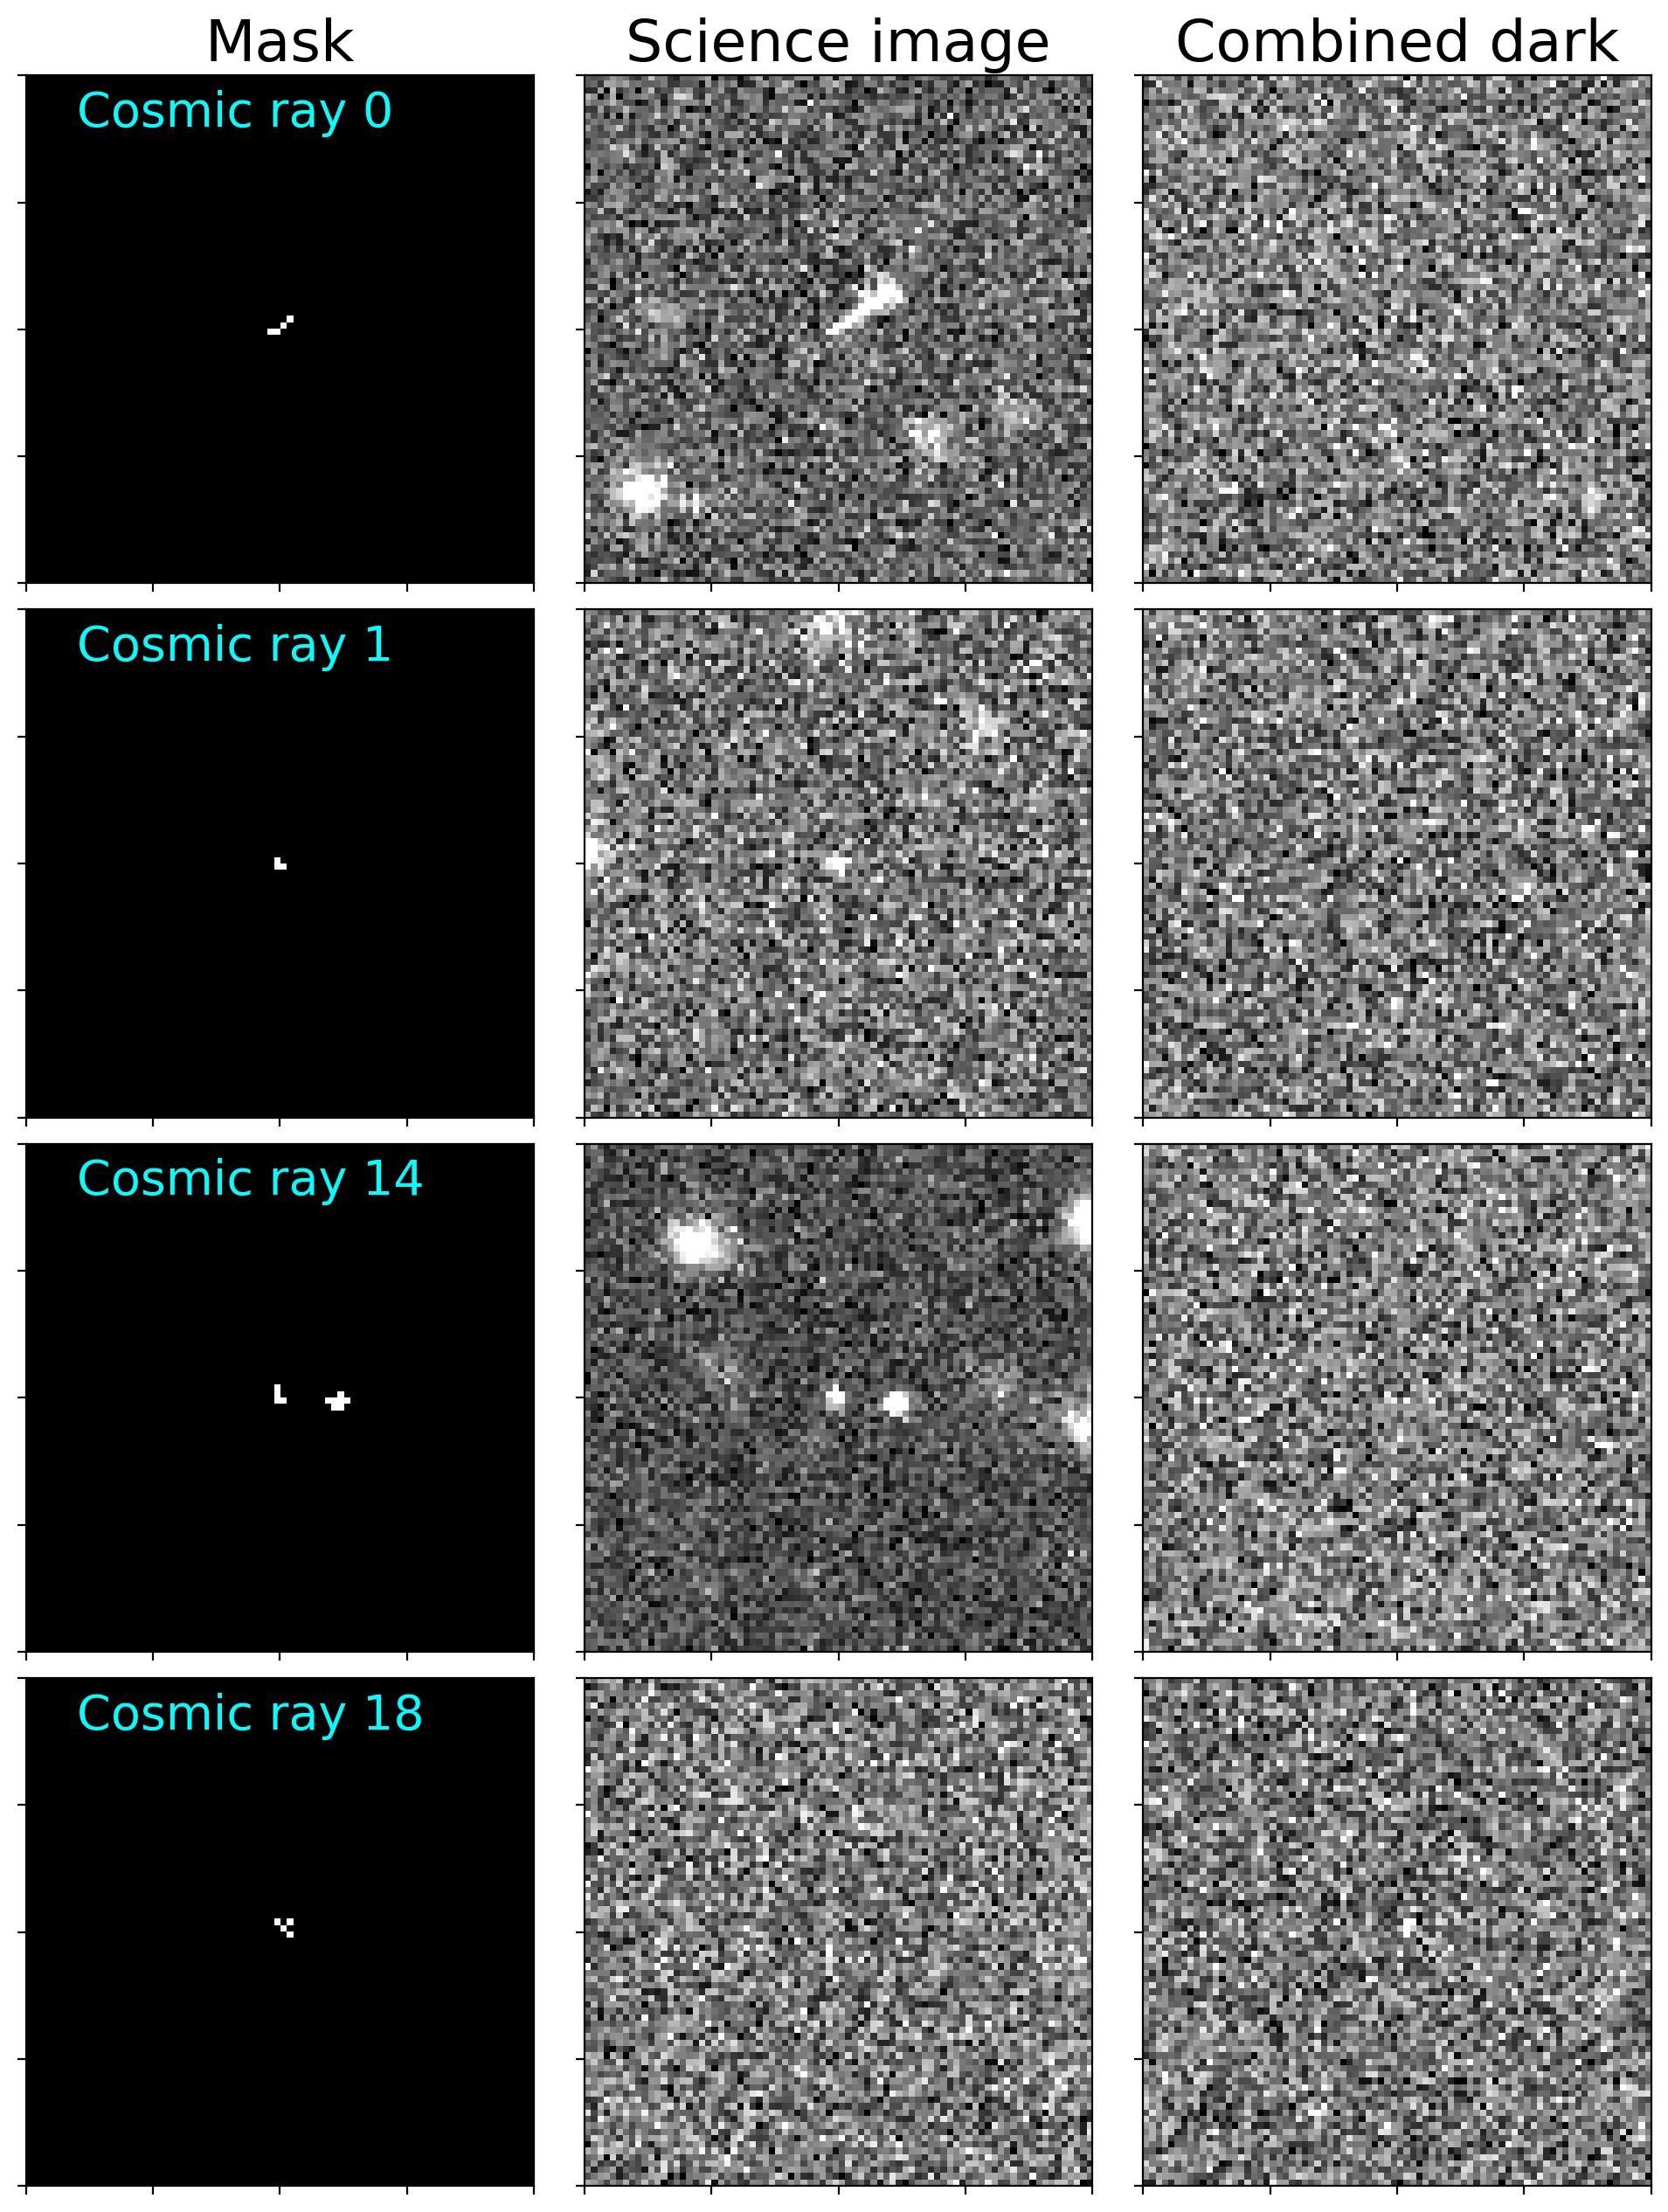

In [18]:
images_to_display = [new_ccd.mask, ccd, ccd_dark]
image_titles = ['Mask', 'Science image', 'Combined dark']
display_cosmic_rays(crs, images_to_display, titles=image_titles,
                    only_display_rays=[0, 1, 14, 18]
                   )

### Discussion of sample cosmic rays

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R448){:target="_blank"}

The first three examples above, labeled "Cosmic ray 0," "Cosmic ray 1" and
"Cosmic ray 14," are straightforward; each is actually a cosmic ray.

The fourth, "Cosmic ray 18", is not a cosmic ray, though it does correspond to a
defect in the CCD. It is caused by a single  hot pixel (dark current around
2$e^-$/sec) that has a  high value in the combined dark frame. When that
combined dark is subtracted from the science image it causes a large *negative*
value in the value in the science image which ends up being identified as a
cosmic ray.

### Saving the mask with the image

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R465){:target="_blank"}

To save the full mask, including cosmic rays, hot pixels, and pixels identified
by `ccdmask`, set the mask of `ccd` to the mask of `new_ccd`. In some use cases
you might prefer to save `new_ccd` itself. The difference between the two is
that the pixel values in which there are cosmic rays have been replaced in
`new_ccd` by values representative of the surrounding pixels.

In [19]:
ccd.mask = new_ccd.mask

# This saves both the image and the mask
ccd.write('example-with-cosmic-rays.fits')

## What happens if you do not mask?

In the example above we masked the pixels known to be bad in all of the images
before detecting cosmic rays. It is possible to do cosmic ray detection without
prior masking. The downside of not masking is that many features that are not
cosmic rays are identified as cosmic rays, and some real cosmic rays are not
detected.

We begin with a fresh copy of the input image and run cosmic ray detection with
the same parameters as above.

In [20]:
ccd = CCDData.read(ex2_path / 'kelt-16-b-S001-R001-C084-r.fit')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [21]:
%%time
new_ccd_no_premask = ccdp.cosmicray_lacosmic(ccd, readnoise=10, sigclip=7, verbose=True)

Starting 4 L.A.Cosmic iterations
Iteration 1:
239 cosmic pixels this iteration
Iteration 2:
127 cosmic pixels this iteration
Iteration 3:
128 cosmic pixels this iteration
Iteration 4:
109 cosmic pixels this iteration
CPU times: user 22.1 s, sys: 1.43 s, total: 23.5 s
Wall time: 23.5 s


In [22]:
print("Pre-masking detects {} cosmic ray pixels.\nNo pre-masking detects {} cosmic ray pixels.".format(new_ccd.mask.sum(), new_ccd_no_premask.mask.sum()))

Pre-masking detects 160 cosmic ray pixels.
No pre-masking detects 321 cosmic ray pixels.


Many of the additional pixels detected as cosmic rays are in the leftmost column
of the image. The column is actually bad (it is covered on the CCD and receives
no light).

In [23]:
crs_no_premask = detect_sources(new_ccd_no_premask.mask, threshold, n_pixels)

In [24]:
crs_no_premask.areas

array([20, 52,  3,  3, 24,  6,  3,  3,  4,  5,  6,  8,  5,  3,  5,  8,  5,
        3,  3,  5,  4,  3,  5, 45,  3])

### Some of these are not cosmic rays

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/119/files#diff-f6ef62fd37828bd27c81ee882c661db1R566){:target="_blank"}

The display below shows a few examples of areas identified by
`cosmicray_lacosmic` that are not actually cosmic rays. These false positives
are harmless because they reflect real problems with the detector and should be
masked out anyway.

More problematic are the cosmic rays that are undetected if the image is not
masked first. As an example, the cosmic ray labeled "Cosmic ray 0" in the
[example above in which a mask was applied before detecting cosmic rays](#Discussion-of-sample-cosmic-rays) is not detected at all when no masking is done.

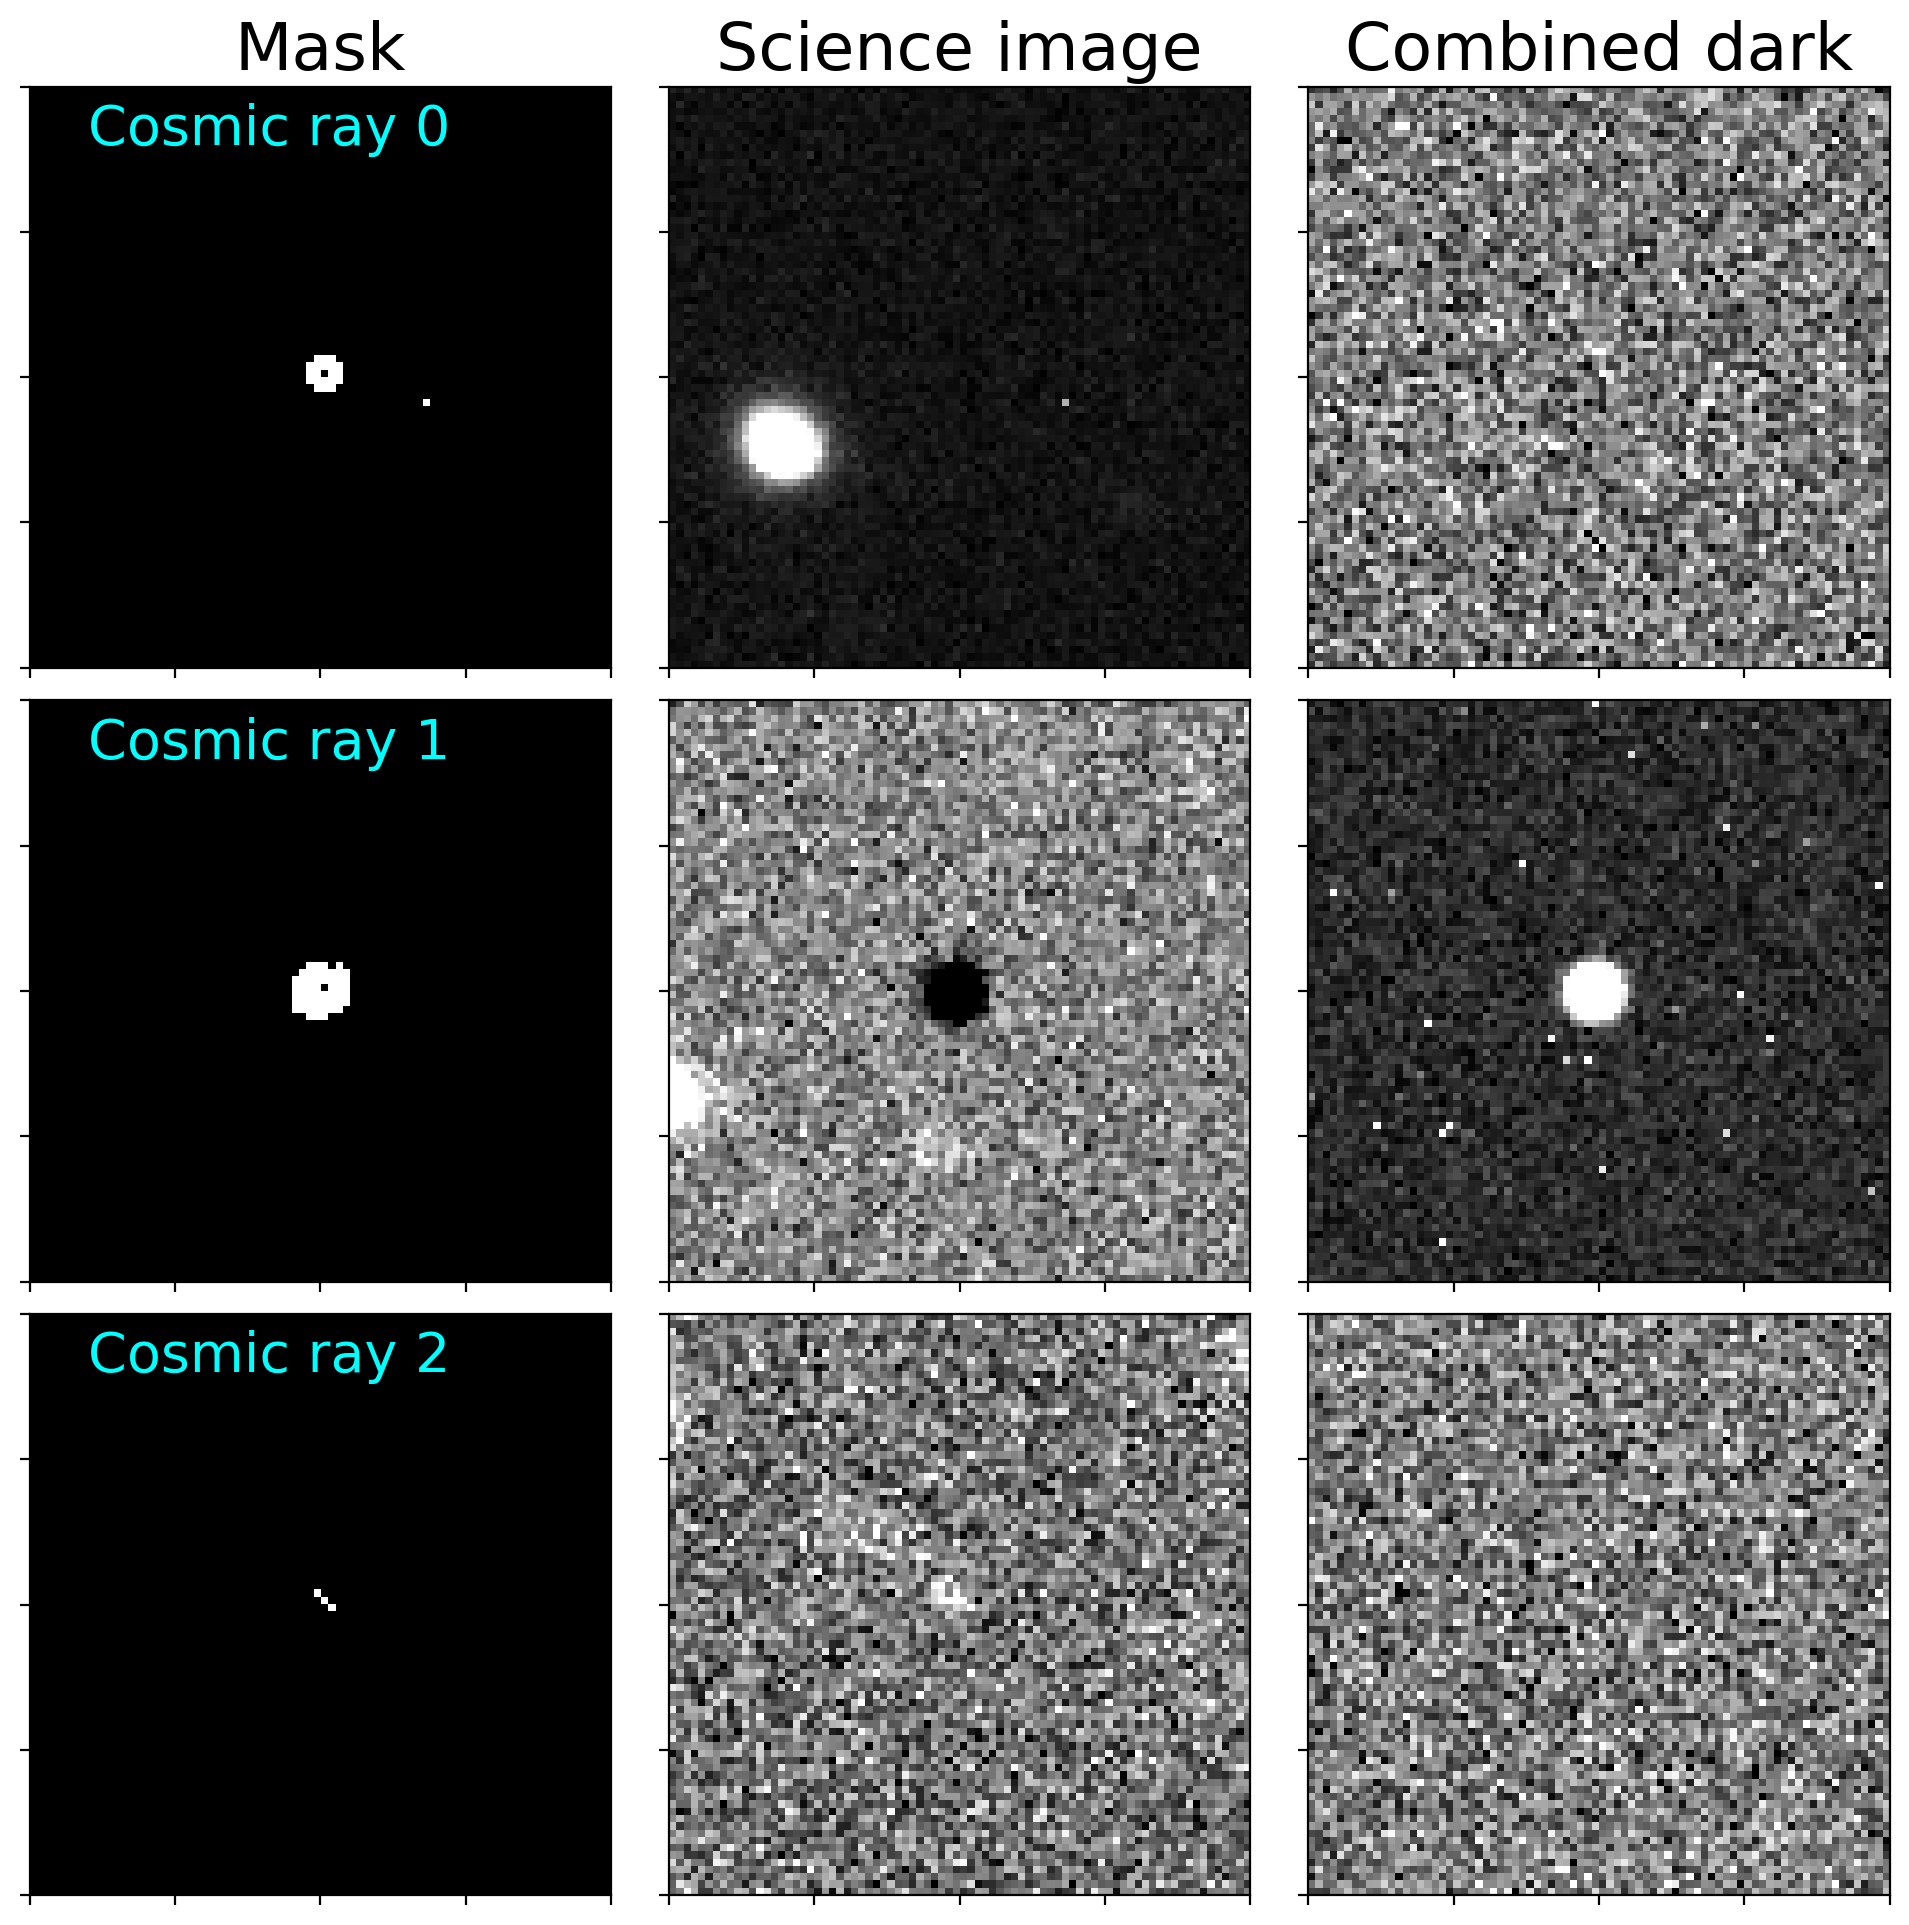

In [25]:
images_to_display = [new_ccd_no_premask.mask, ccd, ccd_dark]
image_titles = ['Mask', 'Science image', 'Combined dark']
display_cosmic_rays(crs_no_premask, images_to_display, titles=image_titles,
                    only_display_rays=[0, 1, 2]
                   )

### Discussion

The first example above is the bad column on the left side of the image.

The one label "Cosmic ray 1" is caused by a single hot pixel with a large count
in the dark frames, which leads to a large negative value in the calibrated
science image. LACosmic tags that pixel and many around it as cosmic rays. While
the individual hot pixel should be masked, the ones around it do not need to be
masked.

The final example, "Cosmic ray 3,", looks a lot like a star. It is, in fact, the
after-image of one of the bright stars in the field of Kelt 16b. Bright stars in
the field of view can deposit enough charge that is does not dissipate between
images. Typically the effect can be avoided altogether by "pre-flashing" the
CCD.

Since one cannot pre-flash after the images have been taken, we are stuck doing
the next best thing: masking out this part of the images. The masking should be
done at the stage at which how pixels are being identified because all of these
pixels will be identified as how.